In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.preprocessing import LabelEncoder
from itertools import product

%matplotlib inline

In [100]:
train = pd.read_csv('../data/sales_history.csv')
item_cat = pd.read_csv('../data/item_categories.csv')
cat_name = pd.read_csv('../data/category_names.csv')
test = pd.read_csv('../data/test.csv', index_col=0)
test2 = pd.read_csv('../data/test.csv', index_col=0)

submit = pd.read_csv('../data/sample_submission.csv')

train.columns = 'date shop_id item_id price item_cnt_day'.split()
test.columns = 'item_id shop_id'.split()
cat_name.columns = 'cat_id cat_name'.split()
item_cat.columns = 'item_id cat_id'.split()
test2.columns = 'item_id shop_id'.split()


In [101]:
train.head()

,date,shop_id,item_id,price,item_cnt_day
0,2018-01-01,9,1000001,420,1.0
1,2018-01-01,6,1000001,420,1.0
2,2018-01-01,10,1000001,420,1.0
3,2018-01-01,0,1000017,250,1.0
4,2018-01-01,1,1000017,250,1.0


In [102]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119570 entries, 0 to 1119569
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   date          1119570 non-null  object 
 1   shop_id       1119570 non-null  int64  
 2   item_id       1119570 non-null  int64  
 3   price         1119570 non-null  int64  
 4   item_cnt_day  1119570 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 42.7+ MB


In [103]:
train[train.item_cnt_day> 120]

,date,shop_id,item_id,price,item_cnt_day
516829,2018-10-06,9,1100302,1020,135.0
946871,2019-06-20,9,1100336,130,151.0


In [104]:
train = train[train.price <200000]
train = train[train.item_cnt_day < 120]
train.price.max()

71400

In [105]:
train.loc[train.item_cnt_day < 0 ,'item_cnt_day'] = 0

In [106]:
train[train.item_id<0]

,date,shop_id,item_id,price,item_cnt_day


In [107]:
cat_name.columns

Index(['cat_id', 'cat_name'], dtype='object')

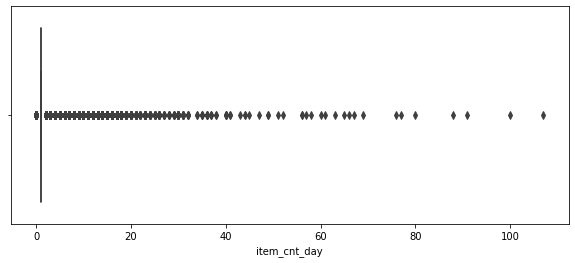

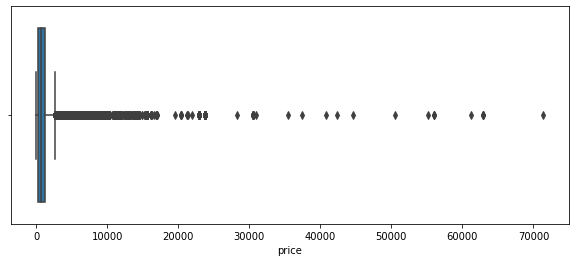

In [108]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
sns.boxplot(x=train.price)

In [109]:
def add_monthly_idx(x):
    if x >= '2018-01-01' and x < '2018-02-01':
        return 0
    elif x >= '2018-02-01' and x < '2018-03-01':
        return 1
    elif x >= '2018-03-01' and x < '2018-04-01':
        return 2
    elif x >= '2018-04-01' and x < '2018-05-01':
        return 3
    elif x >= '2018-05-01' and x < '2018-06-01':
        return 4
    elif x >= '2018-06-01' and x < '2018-07-01':
        return 5
    elif x >= '2018-07-01' and x < '2018-08-01':
        return 6
    elif x >= '2018-08-01' and x < '2018-09-01':
        return 7
    elif x >= '2018-09-01' and x < '2018-10-01':
        return 8
    elif x >= '2018-10-01' and x < '2018-11-01':
        return 9
    elif x >= '2018-11-01' and x < '2018-12-01':
        return 10
    elif x >= '2018-12-01' and x < '2019-01-01':
        return 11
    elif x >= '2019-01-01' and x < '2019-02-01':
        return 12
    elif x >= '2019-02-01' and x < '2019-03-01':
        return 13
    elif x >= '2019-03-01' and x < '2019-04-01':
        return 14
    elif x >= '2019-04-01' and x < '2019-05-01':
        return 15
    elif x >= '2019-05-01' and x < '2019-06-01':
        return 16
    elif x >= '2019-06-01' and x < '2019-07-01':
        return 17
    elif x >= '2019-07-01' and x < '2019-08-01':
        return 18
    elif x >= '2019-08-01' and x < '2019-09-01':
        return 19
    elif x >= '2019-09-01' and x < '2019-10-01':
        return 20
    elif x >= '2019-10-01' and x < '2019-11-01':
        return 21
    else:
        return 22 


In [110]:
train['month_idx'] = train['date'].apply(add_monthly_idx)

In [111]:
cat_name['sprit'] = cat_name['cat_name'].str.split('-')
cat_name['type'] = cat_name['sprit'].map(lambda x: x[0].strip())
cat_name['type_code'] = LabelEncoder().fit_transform(cat_name['type'])
cat_name = cat_name[['cat_id','type_code']]

In [112]:
train['month_idx'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [113]:
train['shop_id'].unique()

array([ 9,  6, 10,  0,  1, 13,  8,  2, 15, 14,  5,  7, 16, 11, 12,  3,  4,
       17])

In [114]:
matrix = []
cols = ['month_idx','shop_id', 'item_id']

for i in range(22):
    sales = train[train.month_idx==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int64'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)    
matrix['month_idx'] = matrix['month_idx'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int64)

matrix.sort_values(cols, inplace=True)

In [115]:
matrix.head()

,month_idx,shop_id,item_id
13860,0,0,1000001
14478,0,0,1000002
16299,0,0,1000003
14479,0,0,1000004
14480,0,0,1000005


In [116]:
train['revenue'] = train['price'] * train['item_cnt_day']


In [117]:
group = train.groupby(['month_idx', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns= ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
                                


In [118]:
test['month_idx'] = 22
test['month_idx'] = test['month_idx'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int64)


In [119]:
test2['month_idx'] = 23
test2['month_idx'] = test2['month_idx'].astype(np.int8)
test2['shop_id'] = test2['shop_id'].astype(np.int8)
test2['item_id'] = test2['item_id'].astype(np.int64)


In [120]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0,inplace=True)


In [121]:
matrix = pd.concat([matrix, test2], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0,inplace=True)


In [122]:
matrix = pd.merge(matrix, item_cat, on=['item_id'], how='left')
matrix = pd.merge(matrix, cat_name, on=['cat_id'], how='left')


In [123]:
matrix.head()

,month_idx,shop_id,item_id,item_cnt_month,cat_id,type_code
0,0,0,1000001,6.0,100,5
1,0,0,1000002,2.0,100,5
2,0,0,1000003,0.0,100,5
3,0,0,1000004,1.0,100,5
4,0,0,1000005,8.0,100,5


In [124]:
group = matrix.groupby(['month_idx']).agg({'item_cnt_month':['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)


In [125]:
def lag_feature(df, lags, col):
    tmp = df[['month_idx', 'shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['month_idx','shop_id', 'item_id', col+'_lag_'+str(i)]
        shifted['month_idx'] += i
        df = pd.merge(df, shifted, on=['month_idx','shop_id','item_id'], how='left')
    return df

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')    


In [128]:

group = matrix.groupby(['month_idx']).agg({'item_cnt_month':['mean']})
group.columns = ['date_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)




group = matrix.groupby(['month_idx','shop_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx', 'shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,4,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)


group = matrix.groupby(['month_idx','cat_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx','cat_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True )


group = matrix.groupby(['month_idx','shop_id','cat_id']).agg({'item_cnt_month':['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx','shop_id','cat_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)



In [129]:
group = train.groupby(['item_id']).agg({'price':['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)


group = train.groupby(['month_idx','item_id']).agg({'price':['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix= lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price'])/matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0


matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price','date_item_avg_item_price']

for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

 

In [130]:
group = train.groupby(['month_idx','shop_id']).agg({'revenue':['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['month_idx','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)


group = group.groupby(['shop_id']).agg({'date_shop_revenue':['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue']-matrix['shop_avg_revenue'])/matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'delta_revenue')
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)


In [131]:
matrix['month'] = matrix['month_idx'] % 12 

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)


In [132]:
matrix

,month_idx,shop_id,item_id,item_cnt_month,cat_id,type_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,...,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_4,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,0,0,1000001,6.0,100,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
1,0,0,1000002,2.0,100,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
2,0,0,1000003,0.0,100,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
3,0,0,1000004,1.0,100,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
4,0,0,1000005,8.0,100,5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655023,23,13,3500001,0.0,350,6,0.0,2.0,3.0,1.0,...,1.216797,1.300781,1.180664,1.705078,0.0,0.0,0.0,NaN,11,31
1655024,23,14,3500001,0.0,350,6,0.0,0.0,0.0,0.0,...,0.344238,0.394531,0.369141,0.659668,0.0,0.0,0.0,NaN,11,31
1655025,23,15,3500001,0.0,350,6,0.0,0.0,0.0,0.0,...,0.490967,0.502441,0.414062,0.640137,0.0,0.0,0.0,NaN,11,31
1655026,23,16,3500001,0.0,350,6,0.0,0.0,0.0,0.0,...,0.395508,0.479004,0.342773,0.544434,0.0,0.0,0.0,NaN,11,31


In [133]:
matrix.columns

Index(['month_idx', 'shop_id', 'item_id', 'item_cnt_month', 'cat_id',
       'type_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1_x', 'date_item_avg_item_cnt_x',
       'date_avg_item_cnt_lag_1_y', 'date_item_avg_item_cnt_y',
       'date_avg_item_cnt_lag_1', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_4',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'delta_price_lag', 'delta_revenue_lag_1', 'month', 'days'],
      dtype='object')

In [134]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month !=0:
            cache[key] = row.month_idx
    else:
        last_date_block_num = cache[key]
        if row.month_idx > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.month_idx - last_date_block_num
            cache[key] = row.month_idx


In [135]:
matrix['item_shop_first_sale'] = matrix['month_idx'] - matrix.groupby(['item_id','shop_id'])['month_idx'].transform('min')
matrix['item_first_sale'] = matrix['month_idx'] - matrix.groupby('item_id')['month_idx'].transform('min')


In [136]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)
    return df


matrix = fill_na(matrix)


In [137]:
import pickle

In [138]:
matrix.to_pickle('data.pkl')
